# SSD384 Training Tutorial

## Setup

In [1]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from ssd.models.effnetv2_ssd384 import EfficientNetV2
from ssd.keras_loss_function.keras_ssd_loss import SSDLoss
from ssd.keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from ssd.keras_layers.keras_layer_DecodeDetections import DecodeDetections
from ssd.keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from ssd.keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd.ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd.ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from ssd.data_generator.object_detection_2d_data_generator import DataGenerator
from ssd.data_generator.object_detection_2d_geometric_ops import Resize
from ssd.data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from ssd.data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from ssd.data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

## Parameters

In [19]:
dataset_base_dir = r'C:\Users\dsclub\Desktop\Hammond\VOCdevkit\\'
weights_path = None #r'C:\Users\dsclub\Desktop\Hammond\VGG_VOC0712Plus_SSD_300x300_ft_iter_160000.h5'
model_path = None
model_checkpoint_path = 'chpt\effnet_ssd384_model_'
log_path = 'effnet_ssd385_'
build = True
save_hdf5 = False
load_hdf5 = False
load_all_in_memory = True
hdf5_train_path = ''
hdf5_val_path = ''
batch_size = 32

## Model configuration parameters

In [16]:
img_height = 384 # Height of the model input images
img_width = 384 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 20 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 128, 384]
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

## Build or load the model

In [22]:
K.clear_session() # Clear previous models from memory.

if build:
    model, predictor_sizes = EfficientNetV2(
        n_classes=n_classes,
        mode='training',
        scales=scales,
        aspect_ratios_per_layer=aspect_ratios,
        two_boxes_for_ar1=two_boxes_for_ar1,
        offsets=offsets,
        clip_boxes=clip_boxes,
        variances=variances,
        normalize_coords=normalize_coords,
        return_predictor_sizes=True
    )

    if weights_path is not None:
        model.load_weights(weights_path, by_name=True)

    sgd = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    #sgd = SGD(learning_rate=0.001, momentum=0.9, decay=0.0, nesterov=False)
    
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.compile(optimizer=sgd, loss=ssd_loss.compute_loss)
else:
    model_path = 'path/to/trained/model.h5'
    
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    
    model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                                   'L2Normalization': L2Normalization,
                                                   'compute_loss': ssd_loss.compute_loss})
    predictor_sizes = np.array([
        model.get_layer(f'conv_pred_class_{i}').output_shape[1:3]
        for i in range(6)
    ])

1 0 1
2 0 2
3 0 3
5 0 4


C:\ProgramData\Anaconda3\envs\AIGPU\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 384, 384, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 192, 192, 24) 648         rescaling[0][0]                  
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 192, 192, 24) 96          stem_conv[0][0]                  
______________________________________________________________________________________________

In [8]:
from ssd.models.efficientnet_v2 import EfficientNetV2S
model2 = EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_shape=(384, 384, 3),
)
for layer in model2.layers:
    try:
        if len(layer.weights) > 0:
            layer2 = model.get_layer(layer.name)
            layer2.set_weights(layer.get_weights())
            layer2.trainable = False
    except Exception as e:
        print(e)

No such layer: top_conv.
No such layer: top_bn.


## Data Generators

In [11]:
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

if load_hdf5:
    train_dataset = DataGenerator(load_images_into_memory=load_all_in_memory,
                                  hdf5_dataset_path=hdf5_train_path)
    val_dataset = DataGenerator(load_images_into_memory=load_all_in_memory,
                                hdf5_dataset_path=hdf5_val_path)
else:
    train_dataset = DataGenerator(load_images_into_memory=load_all_in_memory,
                                  hdf5_dataset_path=None)
    val_dataset = DataGenerator(load_images_into_memory=load_all_in_memory,
                                hdf5_dataset_path=None)

    VOC_2007_images_dir      = dataset_base_dir + 'VOC2007/JPEGImages/'
    VOC_2007_test_images_dir = dataset_base_dir + 'VOC2007test/JPEGImages/'
    VOC_2012_images_dir      = dataset_base_dir + 'VOC2012/JPEGImages/'

    VOC_2007_annotations_dir      = dataset_base_dir + 'VOC2007/Annotations/'
    VOC_2007_test_annotations_dir = dataset_base_dir + 'VOC2007test/Annotations/'
    VOC_2012_annotations_dir      = dataset_base_dir + 'VOC2012/Annotations/'

    VOC_2007_train_image_set_filename    = dataset_base_dir + 'VOC2007/ImageSets/Main/train.txt'
    VOC_2012_train_image_set_filename    = dataset_base_dir + 'VOC2012/ImageSets/Main/train.txt'
    VOC_2007_val_image_set_filename      = dataset_base_dir + 'VOC2007/ImageSets/Main/val.txt'
    VOC_2012_val_image_set_filename      = dataset_base_dir + 'VOC2012/ImageSets/Main/val.txt'
    VOC_2007_trainval_image_set_filename = dataset_base_dir + 'VOC2007/ImageSets/Main/trainval.txt'
    VOC_2012_trainval_image_set_filename = dataset_base_dir + 'VOC2012/ImageSets/Main/trainval.txt'
    VOC_2007_test_image_set_filename     = dataset_base_dir + 'VOC2007test/ImageSets/Main/test.txt'

    train_dataset.parse_xml(images_dirs=[VOC_2007_images_dir,
                                         VOC_2012_images_dir],
                            image_set_filenames=[VOC_2007_trainval_image_set_filename,
                                                 VOC_2012_trainval_image_set_filename],
                            annotations_dirs=[VOC_2007_annotations_dir,
                                              VOC_2012_annotations_dir],
                            classes=classes,
                            include_classes='all',
                            exclude_truncated=False,
                            exclude_difficult=False,
                            ret=False)

    val_dataset.parse_xml(images_dirs=[VOC_2007_test_images_dir],
                          image_set_filenames=[VOC_2007_test_image_set_filename],
                          annotations_dirs=[VOC_2007_test_annotations_dir],
                          classes=classes,
                          include_classes='all',
                          exclude_truncated=False,
                          exclude_difficult=True,
                          ret=False)

if save_hdf5:
    train_dataset.create_hdf5_dataset(file_path=hdf5_train_path,
                                      resize=False,
                                      variable_image_size=True,
                                      verbose=True)

    val_dataset.create_hdf5_dataset(file_path=hdf5_val_path,
                                    resize=False,
                                    variable_image_size=True,
                                    verbose=True)

Loading images into memory: 100%|████████████████████████████████████████| 4952/4952 [00:11<00:00, 418.70it/s]


In [23]:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	 16551
Number of images in the validation dataset:	  4952


## Training Parameters

In [24]:
def lr_schedule(epoch):
    if epoch < 80:
        return 0.001
    elif epoch < 100:
        return 0.0001
    else:
        return 0.00001

In [25]:
model_checkpoint = ModelCheckpoint(filepath=model_checkpoint_path + 'epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   save_freq='epoch')
model_checkpoint.best = 6

csv_logger = CSVLogger(filename=log_path + 'training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]

## Train

In [ ]:
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 120
steps_per_epoch = 1000#// batch_size

history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=final_epoch,
                    callbacks=callbacks,
                    validation_data=val_generator,
                    validation_steps=ceil(val_dataset_size/batch_size),
                    initial_epoch=initial_epoch)

Epoch 1/120

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
 113/1000 [==>...........................] - ETA: 21:07 - loss: 75.8110

## Make predictions

In [13]:
shuffle = True
predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=shuffle,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

Image: C:/Users/dsclub/Desktop/Hammond/VOCdevkit/VOC2007test/JPEGImages/008149.jpg

Ground truth boxes:

[[ 12   2  22 412 375]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  8.     0.28  18.    22.   406.   364.  ]
 [ 12.     0.78  28.    26.   412.   362.  ]]


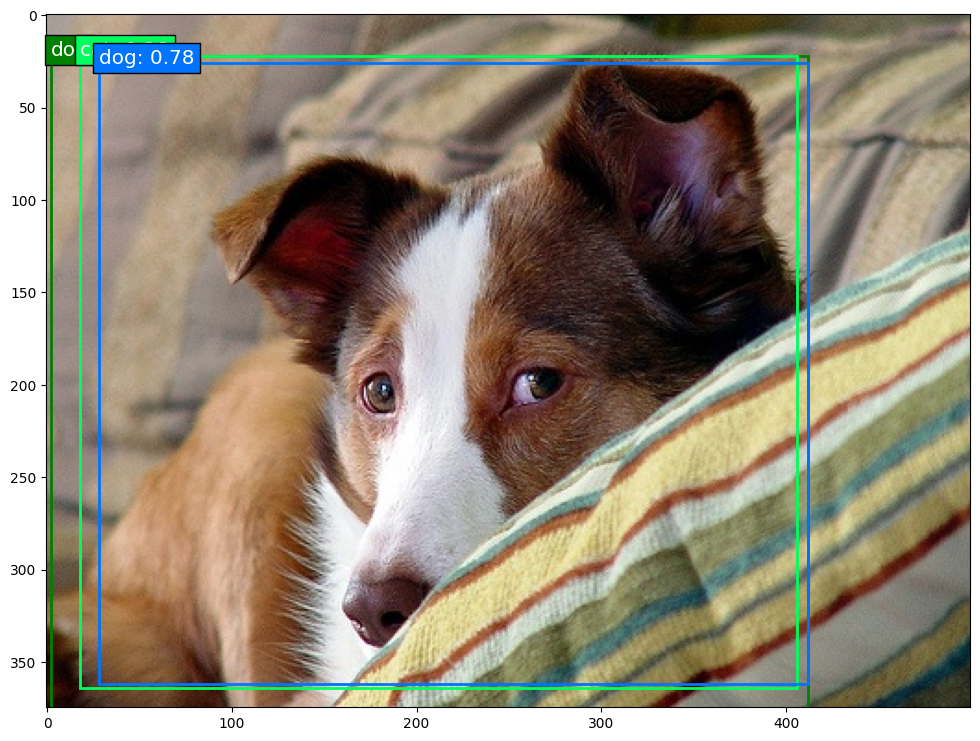

In [79]:
batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

y_pred = model.predict(batch_images)


# Note the comments below for this
y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.2,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)


y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])


# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

plt.figure(figsize=(15,9))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

Decoding the raw predictions in `y_pred`.

Had we created the model in 'inference' or 'inference_fast' mode, then the model's final layer would be a `DecodeDetections` layer and `y_pred` would already contain the decoded predictions, but since we created the model in 'training' mode, the model outputs raw predictions that still need to be decoded and filtered. This is what the `decode_detections()` function is for. It does exactly what the `DecodeDetections` layer would do, but using Numpy instead of TensorFlow (i.e. on the CPU instead of the GPU).

`decode_detections()` with default argument values follows the procedure of the original SSD implementation: First, a very low confidence threshold of 0.01 is applied to filter out the majority of the predicted boxes, then greedy non-maximum suppression is performed per class with an intersection-over-union threshold of 0.45, and out of what is left after that, the top 200 highest confidence boxes are returned. Those settings are for precision-recall scoring purposes though. In order to get some usable final predictions, we'll set the confidence threshold much higher, e.g. to 0.5, since we're only interested in the very confident predictions.